## ResNet50 Representation Analysis

In [ ]:

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

### ResNet50 with classifier head trained on PACS photo-only subset

In [2]:
model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
model.fc = torch.nn.Linear(model.fc.in_features, 7)
state_dict = torch.load('models/resnet50-pacs-1-photo-only.pth')
model.load_state_dict(state_dict)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()


In [3]:
features = {
    "early_layer1": [],
    "middle_layer3": [],
    "final_avgpool": []
}

def get_features(name):
    def hook(module, input, output):
        if name in ["early_layer1", "middle_layer3"]:
            pooled = torch.nn.functional.adaptive_avg_pool2d(output, (1,1))
            features[name].append(pooled.detach().cpu())
        else:
            features[name].append(output.detach().cpu())
    return hook

hooks = []
hooks.append(model.layer1.register_forward_hook(get_features("early_layer1")))
hooks.append(model.layer3[5].register_forward_hook(get_features("middle_layer3")))  
hooks.append(model.avgpool.register_forward_hook(get_features("final_avgpool")))

### Using CIFAR-10 + PACS (sketch, painting, cartoon) mixed dataset with domain + class labels

In [ ]:
class SavedDataset(Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.images = data["images"]
        self.string_labels = data["labels"]

        class_only = [s.rsplit(" ", 1)[0] for s in self.string_labels]
        self.le = LabelEncoder()
        self.numeric_labels = self.le.fit_transform(class_only)

    def __len__(self):
        return len(self.string_labels)

    def __getitem__(self, idx):
        return self.images[idx], self.numeric_labels[idx]

final_dataset = SavedDataset("data/representation_set.pt")
loader = DataLoader(final_dataset, batch_size=128, shuffle=False, num_workers=0)


### Collecting early (layer 1), middle (layer 3), late (final avgpool) features

In [5]:
def collect_features(model, loader, device, max_samples=2000):
    model.eval()
    feats = {"early": [], "middle": [], "late": []}
    labels = []

    # reset buffers
    for k in features.keys():
        features[k] = []

    collected = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            _ = model(inputs)

            batch_size = inputs.size(0)
            labels.append(targets.cpu())

            if len(features["early_layer1"]) > 0:
                feats["early"].append(features["early_layer1"][-1].flatten(1))
            if len(features["middle_layer3"]) > 0:
                feats["middle"].append(features["middle_layer3"][-1].flatten(1))
            if len(features["final_avgpool"]) > 0:
                feats["late"].append(features["final_avgpool"][-1].flatten(1))

            collected += batch_size
            if collected >= max_samples:
                break

    feats = {k: torch.cat(v, dim=0)[:max_samples].numpy() for k, v in feats.items()}
    labels = torch.cat(labels, dim=0)[:max_samples].numpy()
    return feats, labels

feats, labels = collect_features(model, loader, device)


### t-SNE plot

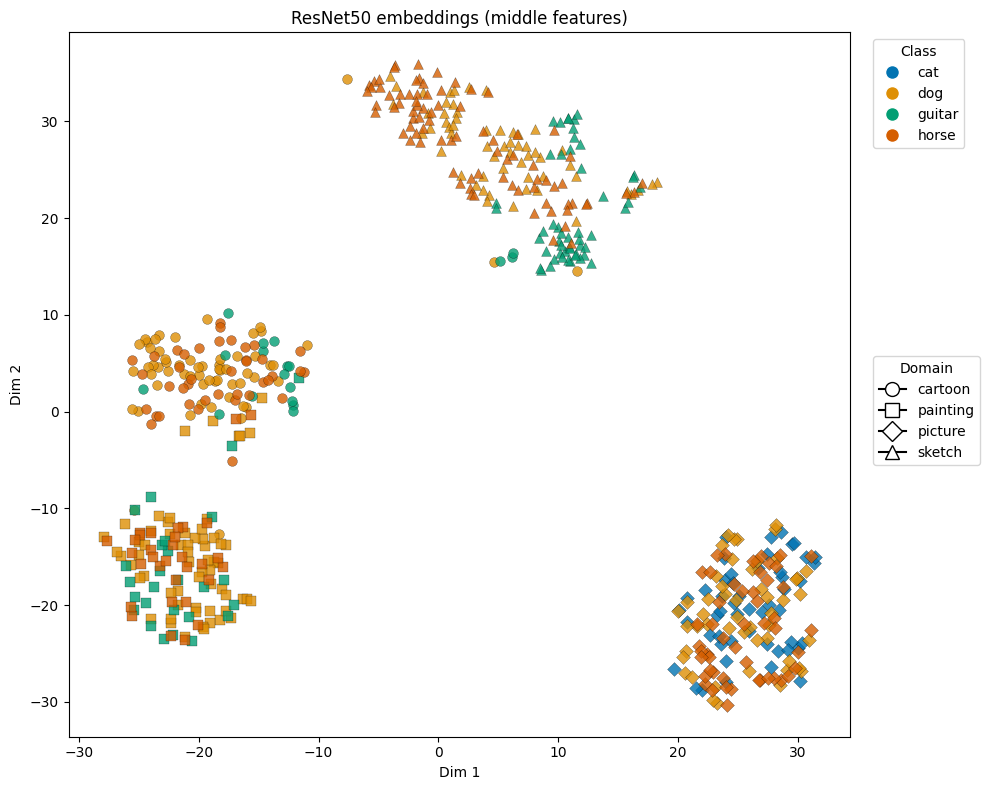

In [ ]:
feature_loc = "early" # "early", "middle", or "late"
features_resnet = feats[feature_loc] 
labels_resnet = np.array(final_dataset.string_labels)   # original string labels ("{class} {domain}")

plot_classes = ["dog", "horse", "cat", "guitar"]

classes = np.array([s.rsplit(" ", 1)[0] for s in labels_resnet])
domains = np.array([s.rsplit(" ", 1)[1] for s in labels_resnet])

mask = np.isin(classes, plot_classes)
X = features_resnet[mask]
classes_plot = classes[mask]
domains_plot = domains[mask]

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X2 = tsne.fit_transform(X)

unique_classes = np.unique(classes_plot)
palette = sns.color_palette("colorblind", n_colors=len(unique_classes))
class2color = {c: palette[i % len(palette)] for i, c in enumerate(unique_classes)}

unique_domains = np.unique(domains_plot)
markers = ["o", "s", "D", "^"]
domain2marker = {d: markers[i % len(markers)] for i, d in enumerate(unique_domains)}

plt.figure(figsize=(10, 8))
ax = plt.gca()

for cls in unique_classes:
    for dom in unique_domains:
        idx = (classes_plot == cls) & (domains_plot == dom)
        if not np.any(idx):
            continue
        ax.scatter(
            X2[idx, 0], X2[idx, 1],
            c=[class2color[cls]],
            marker=domain2marker[dom],
            s=50,
            alpha=0.8,
            edgecolor="k",
            linewidth=0.2,
            label=f"{cls} — {dom}"
        )

ax.set_title(f"ResNet50 embeddings ({feature_loc} features)")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")

class_handles = [
    Line2D([0], [0], marker='o', color='w', label=c,
           markerfacecolor=class2color[c], markersize=10)
    for c in unique_classes
]
domain_handles = [
    Line2D([0], [0], marker=domain2marker[d], color='k', label=d,
           markerfacecolor='w', markersize=10)
    for d in unique_domains
]

legend1 = ax.legend(handles=class_handles, title="Class", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.add_artist(legend1)
ax.legend(handles=domain_handles, title="Domain", bbox_to_anchor=(1.02, 0.55), loc='upper left')

plt.tight_layout()
plt.show()